# ANALYSING CIC 2017 DATASET AND SELECTING BEST FEATURES FOR SLOWLORIS ATTACK


## Index
    1. Data Preparation
    2. Data Split
    3. Feature Selection
    4. PCA

In [1]:
import os
import subprocess
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from __future__ import print_function
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def get_data():
    if os.path.exists("hulk_filtered.csv"):
        print("-- hulk.csv found locally")
    df = pd.read_csv("hulk_filtered.csv", index_col=False)
    return df

In [3]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)
    return (df_mod, targets)

In [4]:
data = get_data()

-- hulk.csv found locally


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# 1.0 Data processing

### We initially drop variables that won't contribute to knowlege of slowloris attack because they change from instance to instance

In [5]:
columns = ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',]
data.drop(columns, inplace=True, axis=1)
print(data.keys())
print(data.shape[0])
print(data.shape[1])

Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd PSH Flags', u' Fwd URG Flags',
       u' Bwd URG Flags', u' Fwd Header Length', u' Bwd Header Length',
       u'Fwd Packets/s', u' Bwd Packets/s', u' Min Packet Length',
       u' Max Packet Length', u' Packet Length Mean', u' Packet Length Std',
       u' Packe

### We also need to convert lables into numeric values for classification

In [6]:
df2, targets = encode_target(data, " Label")



### We drop any rows that contain NaN

In [7]:
df2 = df2.dropna(axis=0, how='any')
df2.isnull().sum().sum()

0

### We also drop columns that have 0 variance

In [8]:
list_unq = (df2.apply(pd.Series.nunique) != 1)
list_unq[list_unq == 0]

 Bwd PSH Flags           False
 Fwd URG Flags           False
 Bwd URG Flags           False
 CWE Flag Count          False
Fwd Avg Bytes/Bulk       False
 Fwd Avg Packets/Bulk    False
 Fwd Avg Bulk Rate       False
 Bwd Avg Bytes/Bulk      False
 Bwd Avg Packets/Bulk    False
Bwd Avg Bulk Rate        False
dtype: bool

In [9]:
df2 = df2.loc[:, df2.apply(pd.Series.nunique) != 1]

# 2.0 Data split
## We split data in features, lables

In [10]:
features = list(df2.columns[:-2])
y = df2["Target"]
X = df2[features]

In [11]:
X

Flow Duration   Total Fwd Packets   Total Backward Packets  \
0                    4                   2                        0   
1                  318                   4                        0   
2                    3                   2                        0   
3                55718                   1                        2   
4                    4                   2                        0   
5                   48                   2                        0   
6                  189                   2                        1   
7                  167                   2                        1   
8                  164                   2                        1   
9                  227                   2                        1   
10                 229                   2                        1   
11                 234                   2                        1   
12                 201                   1                        1   
13                 229                   2                        0   
14                  50                   2                        0   
15                1029                   2                        0   
16                   3                   2                        0   
17                   3                   2                        0   
18             5093368                   8                        6   
19             5093278                   8                        5   
20             5093481                   8                        5   
21             5093427                   8                        6   
22             5093506                   8                        6   
23                  48                   2                        0   
24                  18                   2                        0   
25                  17                   2                        0   
26              414796                   9                        8   
27               32384                   2                        1   
28              138389                   9                        9   
29             5504444                   8                        4   
...                ...                 ...                      ...   
252538          795322                   2                        2   
252539           50755                   1                        1   
252540              45                   1                        1   
252541           66961                   4                        4   
252542             445                   2                        2   
252543             182                   2                        2   
252544             208                   2                        2   
252545             149                   2                        2   
252546             144                   2                        2   
252547           92795                   4                        4   
252548             245                   2                        2   
252549               1                   1                        1   
252550           34806                   4                        1   
252551            6251                   2                        0   
252552           59077                   3                        1   
252553             193                   2                        2   
252554          106063                   2                        2   
252555             210                   2                        2   
252556           23814                   2                        2   
252557           23778                   2                        2   
252558           54624                   4                        4   
252559             229                   2                        2   
252560             278                   2                        2   
252561              62                   1                        1   
252562             210           

1    229777
0     21839
Name: Target, dtype: int64

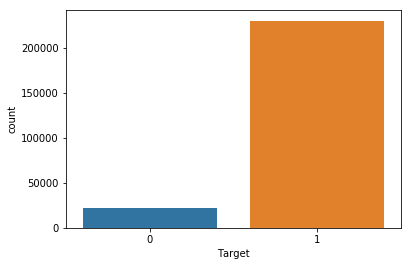

In [12]:
graph = sns.countplot(y ,label="Count")
df2["Target"].value_counts()


In [13]:
value_fig = graph.get_figure()
value_fig.savefig("hulk_data.png")

### df2 is original data frame with neccesary processing done. From now on we make variants of data frame X and Y








# 3.0 Feature Selection


### Index
     3.1 1 Correlation
     3.2 K best features
     3.3 Recursive feature elimination with random forest
     3.4 Recursice feature elimination with cross validation and random forest
     3.5 Tree based feature selection

## 3.1 High Correlation



In [14]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [15]:
upper

Flow Duration   Total Fwd Packets  \
 Flow Duration                           NaN            0.046348   
 Total Fwd Packets                       NaN                 NaN   
 Total Backward Packets                  NaN                 NaN   
Total Length of Fwd Packets              NaN                 NaN   
 Total Length of Bwd Packets             NaN                 NaN   
 Fwd Packet Length Max                   NaN                 NaN   
 Fwd Packet Length Min                   NaN                 NaN   
 Fwd Packet Length Mean                  NaN                 NaN   
 Fwd Packet Length Std                   NaN                 NaN   
Bwd Packet Length Max                    NaN                 NaN   
 Bwd Packet Length Min                   NaN                 NaN   
 Bwd Packet Length Mean                  NaN                 NaN   
 Bwd Packet Length Std                   NaN                 NaN   
 Flow IAT Mean                           NaN                 NaN   
 Flow IAT Std                            NaN                 NaN   
 Flow IAT Max                            NaN                 NaN   
 Flow IAT Min                            NaN                 NaN   
Fwd IAT Total                            NaN                 NaN   
 Fwd IAT Mean                            NaN                 NaN   
 Fwd IAT Std                             NaN                 NaN   
 Fwd IAT Max                             NaN                 NaN   
 Fwd IAT Min                             NaN                 NaN   
Bwd IAT Total                            NaN                 NaN   
 Bwd IAT Mean                            NaN                 NaN   
 Bwd IAT Std                             NaN                 NaN   
 Bwd IAT Max                             NaN                 NaN   
 Bwd IAT Min                             NaN                 NaN   
Fwd PSH Flags                            NaN                 NaN   
 Fwd Header Length                       NaN                 NaN   
 Bwd Header Length                       NaN                 NaN   
...                                      ...                 ...   
 Packet Length Std                       NaN                 NaN   
 Packet Length Variance                  NaN                 NaN   
FIN Flag Count                           NaN                 NaN   
 SYN Flag Count                          NaN                 NaN   
 RST Flag Count                          NaN                 NaN   
 PSH Flag Count                          NaN                 NaN   
 ACK Flag Count                          NaN                 NaN   
 URG Flag Count                          NaN                 NaN   
 ECE Flag Count                          NaN                 NaN   
 Down/Up Ratio                           NaN                 NaN   
 Average Packet Size                     NaN                 NaN   
 Avg Fwd Segment Size                    NaN                 NaN   
 Avg Bwd Segment Size                    NaN                 NaN   
 Fwd Header Length.1                     NaN                 NaN   
Subflow Fwd Packets                      NaN                 NaN   
 Subflow Fwd Bytes                       NaN                 NaN   
 Subflow Bwd Packets                     NaN                 NaN   
 Subflow Bwd Bytes                       NaN                 NaN   
Init_Win_bytes_forward                   NaN                 NaN   
 Init_Win_bytes_backward                 NaN                 NaN   
 act_data_pkt_fwd                        NaN                 NaN   
 min_seg_size_forward                    NaN                 NaN   
Active Mean                              NaN                 NaN   
 Active Std                              NaN                 NaN   
 Active Max                              NaN                 NaN   
 Active Min                              NaN                 NaN   
Idle Mean                                NaN                 NaN   
 Idle Std          

In [16]:
to_drop = [column for column in upper.columns if any(upper[column] == 1.0)]
print(len(to_drop))
print(to_drop)

8
[' SYN Flag Count', ' ECE Flag Count', ' Avg Fwd Segment Size', ' Avg Bwd Segment Size', ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', ' Subflow Bwd Packets']


### 3.1.2 To get an idea who all were correalted perfectly i.e 1.0

In [17]:
corrMatrix = X.corr()
corrMatrix.loc[:,:] =  np.tril(corr_matrix, k=-1)

already_in = set()
result_1 = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] == 1].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result_1.append(perfect_corr)

In [18]:
for element in result_1:
    print(element)

['Subflow Fwd Packets', ' Total Fwd Packets']
[' Subflow Bwd Packets', ' Total Backward Packets']
[' Subflow Fwd Bytes', 'Total Length of Fwd Packets']
[' Avg Fwd Segment Size', ' Fwd Packet Length Mean']
[' Avg Bwd Segment Size', ' Bwd Packet Length Mean']
[' SYN Flag Count', 'Fwd PSH Flags']
[' Fwd Header Length.1', ' Fwd Header Length']
[' ECE Flag Count', ' RST Flag Count']


### 3.1.4 Dropping features with 1 correlation

In [19]:
X_new = X.drop(X[to_drop], axis=1)

In [20]:
X_new.head()

Flow Duration   Total Fwd Packets   Total Backward Packets  \
0               4                   2                        0   
1             318                   4                        0   
2               3                   2                        0   
3           55718                   1                        2   
4               4                   2                        0   

   Total Length of Fwd Packets   Total Length of Bwd Packets  \
0                           31                           0.0   
1                           64                           0.0   
2                           31                           0.0   
3                            0                           0.0   
4                           31                           0.0   

    Fwd Packet Length Max   Fwd Packet Length Min   Fwd Packet Length Mean  \
0                      31                       0                     15.5   
1                      46                       6                     16.0   
2                      31                       0                     15.5   
3                       0                       0                      0.0   
4                      31                       0                     15.5   

    Fwd Packet Length Std  Bwd Packet Length Max    ...      \
0                21.92031                      0    ...       
1                20.00000                      0    ...       
2                21.92031                      0    ...       
3                 0.00000                      0    ...       
4                21.92031                      0    ...       

    act_data_pkt_fwd   min_seg_size_forward  Active Mean  Active Std  \
0                  0                     32          0.0         0.0   
1                  3                     20          0.0         0.0   
2                  0                     32          0.0         0.0   
3                  0                     32          0.0         0.0   
4                  0                     32          0.0         0.0   

   Active Max   Active Min  Idle Mean   Idle Std   Idle Max   Idle Min  
0         0.0          0.0        0.0        0.0        0.0        0.0  
1         0.0          0.0        0.0        0.0        0.0        0.0  
2         0.0          0.0        0.0        0.0        0.0        0.0  
3         0.0          0.0        0.0        0.0        0.0        0.0  
4         0.0          0.0        0.0        0.0        0.0        0.0  

[5 rows x 59 columns]

In [21]:
X_new.isnull().sum().sum()

0

In [22]:
def fix_data_frame(x_train):
    col = x_train.columns[x_train.dtypes.eq(object)]
    x_train[col] = x_train[col].apply(pd.to_numeric, errors='coerce', axis=1)
    return np.nan_to_num(x_train)

In [23]:
def generate_data(x, y, split, seed):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=seed)
    x_train = fix_data_frame(x_train)
    x_test = fix_data_frame(x_test)
    return x_train, x_test, y_train, y_test

In [ ]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [ ]:
x_train, x_test, y_train, y_test = generate_data(X_new, y, 0.3, 21)
ranks = {}
y_train.value_counts()

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


## 3.0 K-best

In [ ]:
select_feature_5 = SelectKBest(f_classif, k=5).fit(x_train, y_train.values)

In [ ]:
scores = select_feature_5.scores_
scores  = [float(i) for i in scores]
features = X_new.columns
    
k_best_f_classif = zip(scores, features)

k_best_f_classif.sort(key= lambda x : x[0], reverse=True)
#for element in k_best_f_classif:
#    print(element[1].lstrip())

ranks["K-Best"] = ranking(scores, X_new.columns)

In [ ]:
k_x = [x[1] for x in k_best_f_classif]
k_y = [x[0] for x in k_best_f_classif]
plt.figure(1, figsize=(30, 23))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), k_y, 0.6,
       color="b", align="edge")
plt.xticks(range(x_train.shape[1]), k_x,rotation=90)
plt.savefig("hulk_kbest.png")

## 3.2 Recursive Feature Elimination using Random Forest

In [ ]:
hyper_optimal = {}


In [ ]:
from sklearn.grid_search import GridSearchCV
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
    grid_search.fit(x_train, y_train.values)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    print("adding parameter ", parameter)
    optimum = df.sort_values([0, 'index'], ascending=[0, 1])[:3]
    val = optimum['index']
    hyper_optimal[parameter] = val
    
    return plot, df

In [ ]:
param_grid_ext = {"n_estimators": np.arange(2, 500, 2),
                "max_depth": np.arange(1, 30, 2),
                "min_samples_split": np.arange(2, 150, 2),
                "min_samples_leaf": np.arange(1, 100, 2),
                "max_leaf_nodes": np.arange(2, 50, 2),
                "min_weight_fraction_leaf": np.arange(0.1, 0.8, 0.1)
             }

In [ ]:
param_grid_ext

In [ ]:
clf = RandomForestClassifier(n_jobs=-1, random_state = 74)
index = 1
this_is_that = plt.figure(figsize=(32,24))
for parameter, param_range in dict.items(param_grid_ext):
    evaluate_param(parameter, param_range, index)
    index += 1

In [ ]:
this_is_that.savefig("hulk_rf_tuning.png")

In [ ]:
param_dict = {}
for key in hyper_optimal.keys():
    param_dict[key] = hyper_optimal[key].tolist()

print(param_dict)

In [ ]:
grid_search = GridSearchCV(clf, param_grid=param_dict, verbose=1)
grid_search.fit(x_train, y_train.values)


In [ ]:
from operator import itemgetter
optimal_parameters = sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[:5][0][0]
optimal_parameters

In [35]:
random_forest = RandomForestClassifier(n_jobs=-1, random_state=74,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       min_weight_fraction_leaf=0.1,
                                       max_leaf_nodes=9,
                                       max_depth=5,
                                       n_estimators=22)

In [36]:
#random_forest = RandomForestClassifier(n_jobs=-1, random_state=74,
#                                       min_samples_leaf=optimal_parameters['min_samples_leaf'],
#                                       min_samples_split=optimal_parameters['min_samples_split'],
#                                       min_weight_fraction_leaf=optimal_parameters['min_weight_fraction_leaf'],
#                                       max_leaf_nodes=optimal_parameters['max_leaf_nodes'],
#                                       max_depth=optimal_parameters['max_depth'],
#                                       n_estimators=optimal_parameters['n_estimators'])

In [37]:
rfe = RFE(estimator=random_forest, n_features_to_select=1)
rfe.fit(x_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=9,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=22, n_jobs=-1,
            oob_score=False, random_state=74, verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [38]:
scores = rfe.ranking_
scores  = [i for i in scores]
    
rfe_rankings_kk = zip(scores, features)

rfe_rankings_kk.sort(key= lambda x : x[0])
#for element in rfe_rankings_kk:
#    print(element)

In [39]:
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), X_new.columns, order=-1)

In [40]:
ranks

{'K-Best': {' ACK Flag Count': 0.06,
  ' Active Max': 0.06,
  ' Active Min': 0.01,
  ' Active Std': 0.04,
  ' Average Packet Size': 0.18,
  ' Bwd Header Length': 0.0,
  ' Bwd IAT Max': 0.0,
  ' Bwd IAT Mean': 0.01,
  ' Bwd IAT Min': 0.02,
  ' Bwd IAT Std': 0.0,
  ' Bwd Packet Length Mean': 0.4,
  ' Bwd Packet Length Min': 0.98,
  ' Bwd Packet Length Std': 0.35,
  ' Bwd Packets/s': 0.06,
  ' Down/Up Ratio': 0.08,
  ' Flow Duration': 0.13,
  ' Flow IAT Max': 0.19,
  ' Flow IAT Mean': 0.13,
  ' Flow IAT Min': 0.0,
  ' Flow IAT Std': 0.18,
  ' Flow Packets/s': 0.02,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.19,
  ' Fwd IAT Mean': 0.13,
  ' Fwd IAT Min': 0.03,
  ' Fwd IAT Std': 0.19,
  ' Fwd Packet Length Max': 0.4,
  ' Fwd Packet Length Mean': 0.52,
  ' Fwd Packet Length Min': 0.84,
  ' Fwd Packet Length Std': 0.35,
  ' Idle Max': 0.19,
  ' Idle Min': 0.18,
  ' Idle Std': 0.0,
  ' Init_Win_bytes_backward': 0.09,
  ' Max Packet Length': 0.18,
  ' Min Packet Length': 1.0,
  ' PSH Flag

### Tree based feature selecion

In [41]:
x_train.shape

(176131, 59)

In [42]:
random_forest_classifier = random_forest.fit(x_train, y_train.values)

In [43]:
importances = random_forest_classifier.feature_importances_

In [46]:
std = np.std([tree.feature_importances_ for tree in random_forest_classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

ranking_tree_based = []
for f in range(x_train.shape[1]):
    print(f + 1, features[indices[f]])
    ranking_tree_based.append(features[indices[f]])

ranking_tree_zip = zip(features[indices], importances[indices])
ranking_tree_zip.sort(key= lambda x : x[1], reverse=True)

for element in ranking_tree_zip:
    print(element[1])
    
ranks["RF"] = ranking(random_forest_classifier.feature_importances_, X_new.columns)

Feature ranking:
1 Flow Bytes/s
2  Fwd Packet Length Mean
3  Bwd Packets/s
4  Fwd Packet Length Max
5  Flow Duration
6  Average Packet Size
7  Packet Length Mean
8  Packet Length Std
9 Fwd Packets/s
10  Subflow Bwd Bytes
11  Max Packet Length
12  Bwd Packet Length Std
13  Total Length of Bwd Packets
14  Init_Win_bytes_backward
15 Bwd Packet Length Max
16  Bwd Packet Length Mean
17  Flow IAT Std
18  Bwd Header Length
19  Flow IAT Mean
20  Packet Length Variance
21 Total Length of Fwd Packets
22  Fwd Packet Length Std
23  Fwd IAT Max
24  Bwd IAT Mean
25  Flow IAT Min
26  Active Max
27  Active Min
28 Init_Win_bytes_forward
29  Flow IAT Max
30  Fwd IAT Mean
31  Flow Packets/s
32  Fwd IAT Std
33  Bwd IAT Max
34  Idle Max
35 Active Mean
36  Total Fwd Packets
37  Bwd Packet Length Min
38  Fwd Packet Length Min
39  Total Backward Packets
40  Idle Min
41 Fwd IAT Total
42  ACK Flag Count
43  Idle Std
44 Idle Mean
45  Active Std
46  min_seg_size_forward
47  act_data_pkt_fwd
48  Down/Up Ratio
49  

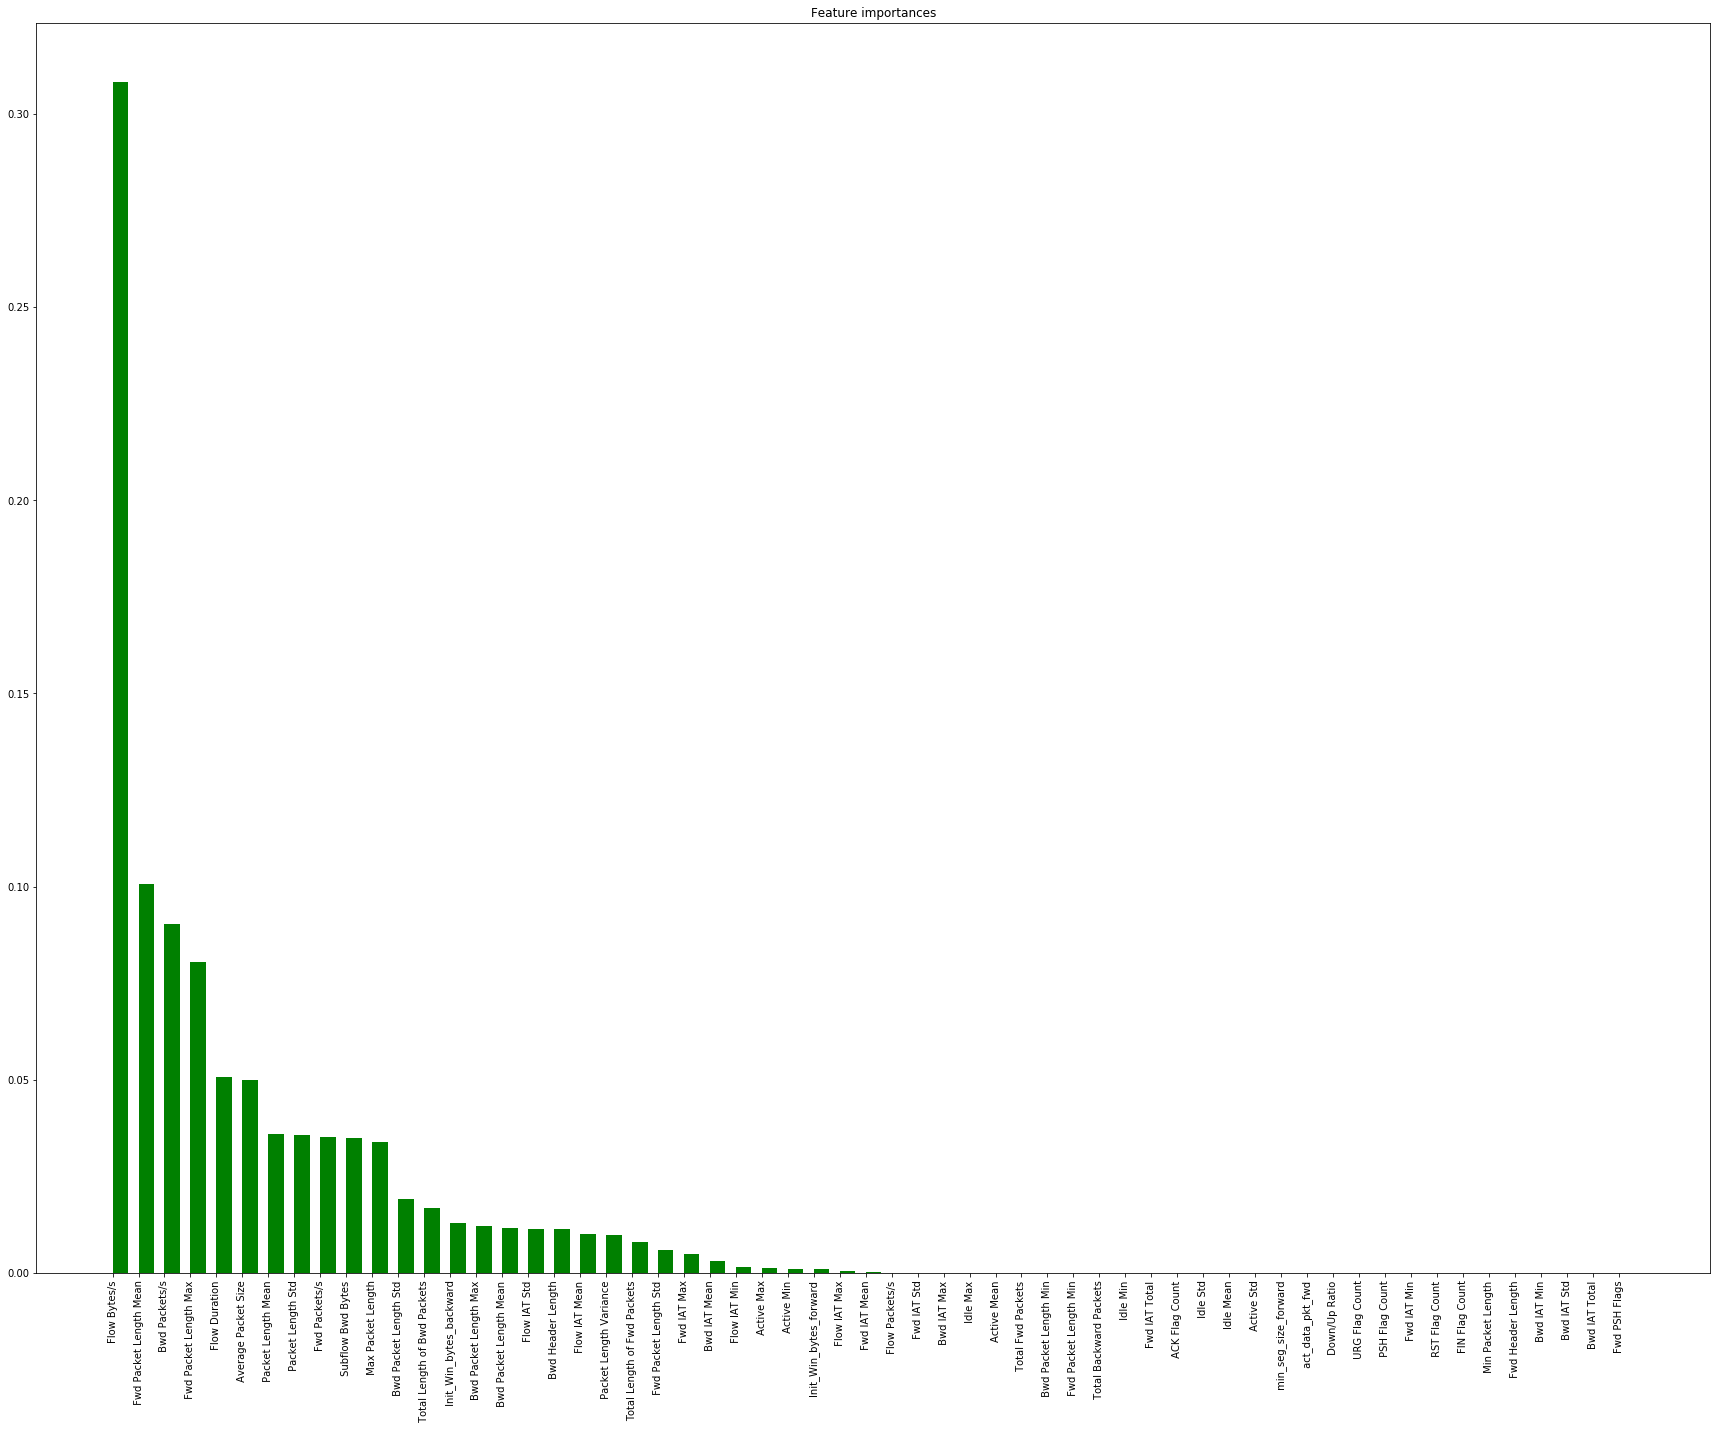

In [47]:
plt.figure(1, figsize=(30, 23))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], 0.6,
       color="g", align="edge")
plt.xticks(range(x_train.shape[1]), X_new.columns[indices],rotation=90)
plt.savefig("rf_features_hulk.png")

## Summary

### 1. Eliminate features with 0 variance
### 2. Eliminate features with 1 correlation
### 3. Estimate feature rankings (various data set sizes) with
        K best
        Recursive feature elimination
        Random Forest

In [48]:
ranks

{'K-Best': {' ACK Flag Count': 0.06,
  ' Active Max': 0.06,
  ' Active Min': 0.01,
  ' Active Std': 0.04,
  ' Average Packet Size': 0.18,
  ' Bwd Header Length': 0.0,
  ' Bwd IAT Max': 0.0,
  ' Bwd IAT Mean': 0.01,
  ' Bwd IAT Min': 0.02,
  ' Bwd IAT Std': 0.0,
  ' Bwd Packet Length Mean': 0.4,
  ' Bwd Packet Length Min': 0.98,
  ' Bwd Packet Length Std': 0.35,
  ' Bwd Packets/s': 0.06,
  ' Down/Up Ratio': 0.08,
  ' Flow Duration': 0.13,
  ' Flow IAT Max': 0.19,
  ' Flow IAT Mean': 0.13,
  ' Flow IAT Min': 0.0,
  ' Flow IAT Std': 0.18,
  ' Flow Packets/s': 0.02,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.19,
  ' Fwd IAT Mean': 0.13,
  ' Fwd IAT Min': 0.03,
  ' Fwd IAT Std': 0.19,
  ' Fwd Packet Length Max': 0.4,
  ' Fwd Packet Length Mean': 0.52,
  ' Fwd Packet Length Min': 0.84,
  ' Fwd Packet Length Std': 0.35,
  ' Idle Max': 0.19,
  ' Idle Min': 0.18,
  ' Idle Std': 0.0,
  ' Init_Win_bytes_backward': 0.09,
  ' Max Packet Length': 0.18,
  ' Min Packet Length': 1.0,
  ' PSH Flag

In [49]:
r = {}
for name in X_new.columns:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t\t\t\t%s" % "\t".join(methods))
for name in X_new.columns:
    print("%s\t\t\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))


				K-Best	RF	RFE	Mean
 Flow Duration			0.13	0.16	0.76	0.35
 Total Fwd Packets			0.0	0.0	0.24	0.08
 Total Backward Packets			0.0	0.0	0.31	0.1
Total Length of Fwd Packets			0.45	0.03	0.67	0.38
 Total Length of Bwd Packets			0.0	0.05	0.81	0.29
 Fwd Packet Length Max			0.4	0.26	0.78	0.48
 Fwd Packet Length Min			0.84	0.0	0.52	0.45
 Fwd Packet Length Mean			0.52	0.33	0.79	0.55
 Fwd Packet Length Std			0.35	0.02	0.64	0.34
Bwd Packet Length Max			0.35	0.04	0.6	0.33
 Bwd Packet Length Min			0.98	0.0	0.21	0.4
 Bwd Packet Length Mean			0.4	0.04	0.93	0.46
 Bwd Packet Length Std			0.35	0.06	0.97	0.46
Flow Bytes/s			0.01	1.0	0.98	0.66
 Flow Packets/s			0.02	0.0	0.91	0.31
 Flow IAT Mean			0.13	0.03	0.86	0.34
 Flow IAT Std			0.18	0.04	0.57	0.26
 Flow IAT Max			0.19	0.0	0.72	0.3
 Flow IAT Min			0.0	0.0	0.47	0.16
Fwd IAT Total			0.13	0.0	0.62	0.25
 Fwd IAT Mean			0.13	0.0	0.69	0.27
 Fwd IAT Std			0.19	0.0	0.71	0.3
 Fwd IAT Max			0.19	0.02	0.66	0.29
 Fwd IAT Min			0.03	0.0	0.22	0.08
Bwd IAT Total			0.0

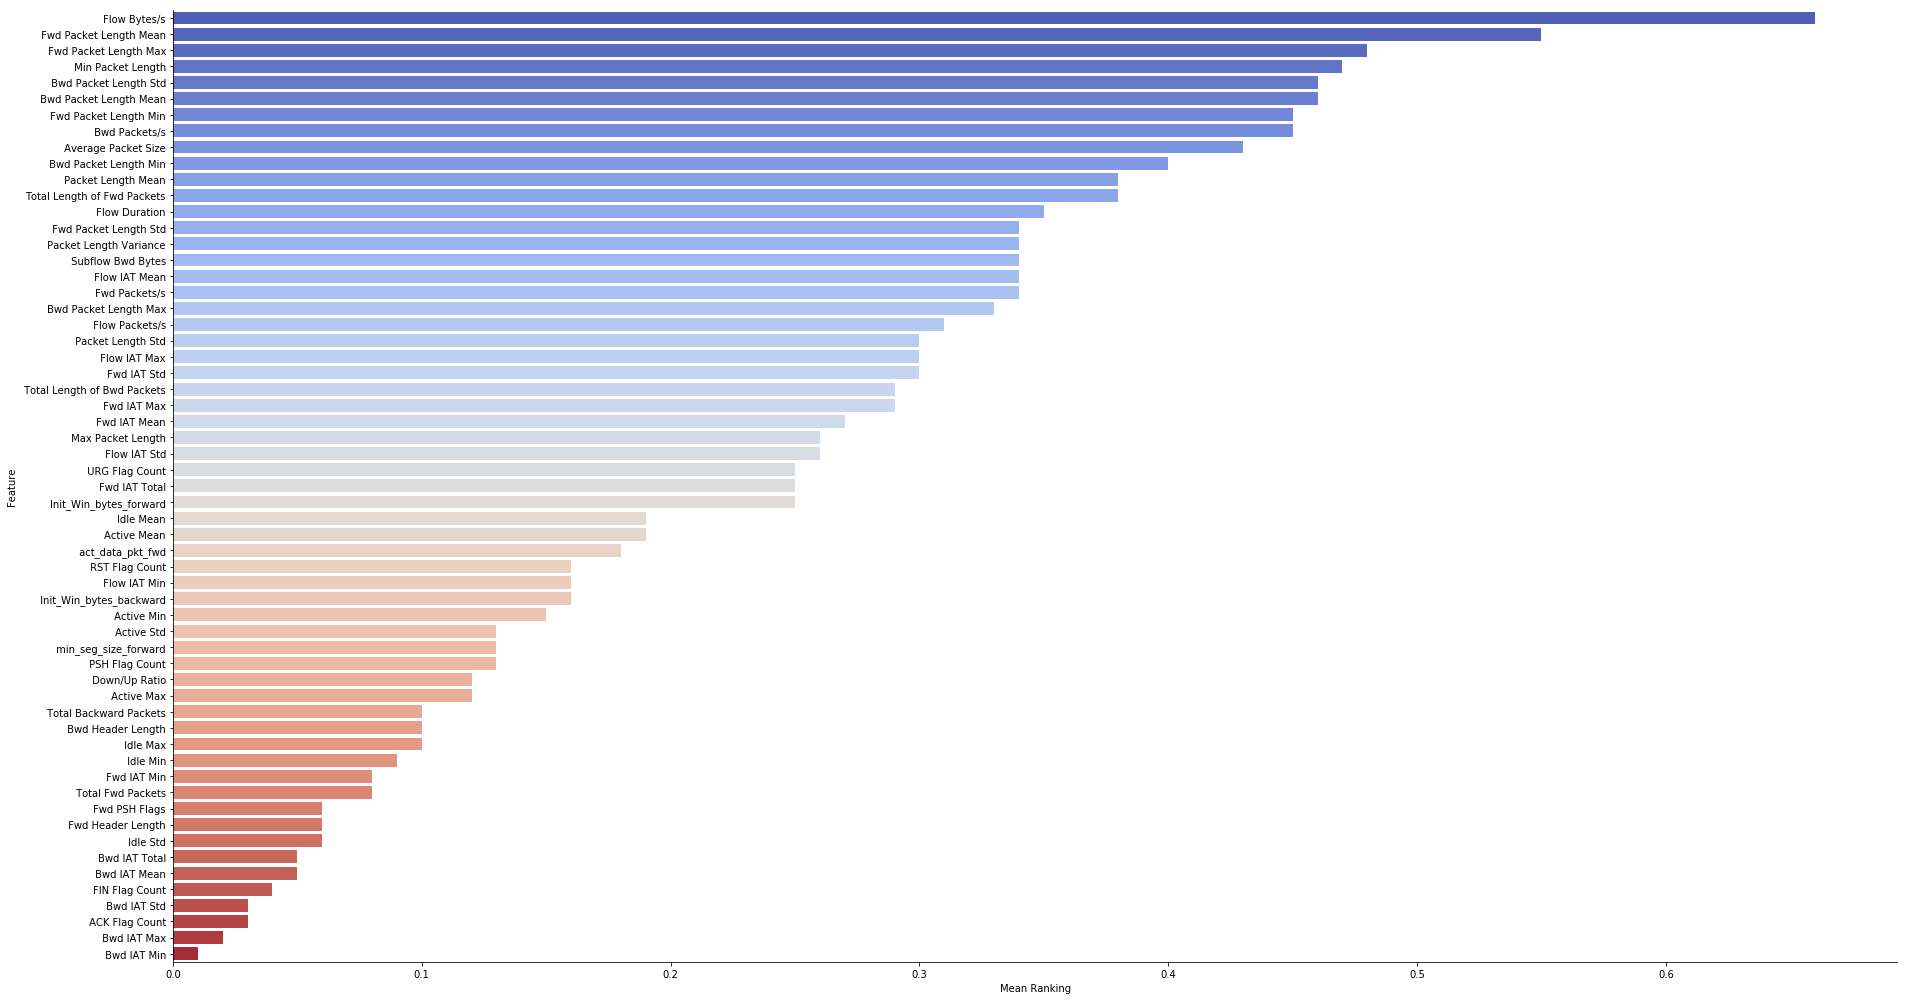

In [50]:
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
y2k = sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')
y2k.savefig("mean_ranking_hulk.png")

In [51]:
meanplot

Feature  Mean Ranking
45                  Flow Bytes/s          0.66
6         Fwd Packet Length Mean          0.55
41         Fwd Packet Length Max          0.48
5              Min Packet Length          0.47
4          Bwd Packet Length Std          0.46
53        Bwd Packet Length Mean          0.46
46         Fwd Packet Length Min          0.45
49                 Bwd Packets/s          0.45
2            Average Packet Size          0.43
27         Bwd Packet Length Min          0.40
55            Packet Length Mean          0.38
48   Total Length of Fwd Packets          0.38
54                 Flow Duration          0.35
21         Fwd Packet Length Std          0.34
17        Packet Length Variance          0.34
29             Subflow Bwd Bytes          0.34
36                 Flow IAT Mean          0.34
13                 Fwd Packets/s          0.34
11         Bwd Packet Length Max          0.33
9                 Flow Packets/s          0.31
23             Packet Length Std          0.30
39                  Flow IAT Max          0.30
57                   Fwd IAT Std          0.30
15   Total Length of Bwd Packets          0.29
50                   Fwd IAT Max          0.29
26                  Fwd IAT Mean          0.27
28             Max Packet Length          0.26
30                  Flow IAT Std          0.26
24                URG Flag Count          0.25
12                 Fwd IAT Total          0.25
56        Init_Win_bytes_forward          0.25
0                      Idle Mean          0.19
7                    Active Mean          0.19
25              act_data_pkt_fwd          0.18
58                RST Flag Count          0.16
51                  Flow IAT Min          0.16
16       Init_Win_bytes_backward          0.16
18                    Active Min          0.15
19                    Active Std          0.13
31          min_seg_size_forward          0.13
14                PSH Flag Count          0.13
8                  Down/Up Ratio          0.12
22                    Active Max          0.12
43        Total Backward Packets          0.10
33             Bwd Header Length          0.10
20                      Idle Max          0.10
32                      Idle Min          0.09
42                   Fwd IAT Min          0.08
37             Total Fwd Packets          0.08
47                 Fwd PSH Flags          0.06
52             Fwd Header Length          0.06
35                      Idle Std          0.06
40                 Bwd IAT Total          0.05
10                  Bwd IAT Mean          0.05
1                 FIN Flag Count          0.04
44                   Bwd IAT Std          0.03
3                 ACK Flag Count          0.03
38                   Bwd IAT Max          0.02
34                   Bwd IAT Min          0.01

## Testing

### Three highest grid scores were obtained at 8, 14 and 25 features. So we use these

In [52]:
#YOU CAN GENERATE DIFFERENT TRAINING SAMPLES HERE at #here. x_train, y_train is 70% by default. 

In [53]:
mean_scores = meanplot["Feature"].tolist()
mean_scores[:4]


['Flow Bytes/s',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Max',
 ' Min Packet Length']

In [54]:
for i in [4]:
    print("\n-------------------------")
    features_selected = mean_scores[:i] 
    print(features_selected)
    x_trial = X_new[features_selected]
    print(x_trial.shape)
    
    #for size in [0.4, 0.5, 0.6]:
    for size in [0.3]:
        training_x, testing_x, training_y, testing_y = generate_data(x_trial, y, size, 42) #here
        #print(training_y.value_counts())
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)


-------------------------
['Flow Bytes/s', ' Fwd Packet Length Mean', ' Fwd Packet Length Max', ' Min Packet Length']
(251616, 4)
Accuracy at 0.3 for 4 is:  0.991455256011128
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      6533
          1       0.99      1.00      1.00     68952

avg / total       0.99      0.99      0.99     75485



### RFE

In [55]:
for i in [4]:
    print("\n-------------------------------------------------------")
    random_forest = RandomForestClassifier()      
    rfe = RFE(estimator=random_forest, n_features_to_select=i, step=1)
    rfe = rfe.fit(x_train, y_train)
    print("RFE features at size " + str(i) + " are \n\n")
    #here
    for el in X_new.columns[rfe.support_]:
        print(el.lstrip())
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.3]:
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on x%
        training_x = rfe.transform(training_x)
        testing_x = rfe.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)

        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)

    


-------------------------------------------------------
RFE features at size 4 are 


Fwd Packet Length Std
Min Packet Length
Init_Win_bytes_forward
Init_Win_bytes_backward
1    160825
0     15306
Name: Target, dtype: int64
(176131, 4)
Accuracy at 0.3 for 4 is:  0.9993906074054448
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



### K Best

In [56]:
for i in [4]:
    print("\n-----------------------------------------")
    select_feature = SelectKBest(f_classif, k=i).fit(x_train, y_train)
    print("Top " + str(i) + " features :", X_new.columns[select_feature.get_support(indices=True)])
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.3]:
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on 70%
    
        training_x = select_feature.transform(training_x)
        testing_x = select_feature.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)
    
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)



-----------------------------------------
Top 4 features : Index([u' Fwd Packet Length Min', u' Fwd Packet Length Mean',
       u' Bwd Packet Length Min', u' Min Packet Length'],
      dtype='object')
1    160825
0     15306
Name: Target, dtype: int64
(176131, 4)
Accuracy at 0.3 for 4 is:  0.9820361661257203
             precision    recall  f1-score   support

          0       0.97      0.82      0.89      6533
          1       0.98      1.00      0.99     68952

avg / total       0.98      0.98      0.98     75485



### Tree based

In [57]:
for i in [4]:
    print("\n-------------------------")
    features_selected = ranking_tree_based[:i] 
    print(features_selected)
    x_trial = X_new[features_selected]
    print(x_trial.shape)
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.3]:
        training_x, testing_x, training_y, testing_y = generate_data(x_trial, y, size, 42) #here
        #print(training_y.value_counts())
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)



-------------------------
['Flow Bytes/s', ' Fwd Packet Length Mean', ' Bwd Packets/s', ' Fwd Packet Length Max']
(251616, 4)
Accuracy at 0.3 for 4 is:  0.9967940650460356
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485

